# Data Exploration Project

## Ziel des Projektes

Das Ziel des Projektes ist es ein ML-Model zu entwickeln welches auf der Basis von frei verfügbaren Online-Schach-Daten der Platform Lichess das Ergebnis eines Spieles voraussagen kann.

Mögliche Ergebnisse sind hierbei:
-  Schwarz gewinnt
-  Weiß gewinnt 
-  Remis

Hierbei handelt es sich somit um eine Klassifikationsaufgabe.

Bevor nun mit der Wahl von Methoden und der Entwicklung des Models gestartet werden kann muss zuerst eine umfassende Datenanalyse durchgeführt werden.

## Data Exploration

Zuerst werfen wir nun einen Blick auf die Daten um die Struktur nachvollziehen zu können. 

Außerdem werden die Verwendeten Bibliotheken importiert.

In [356]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns


In [473]:
df = pd.read_csv('data/games.csv', )

In [474]:
print(df.head())
print(df.shape)

df.info()
print(df.describe())
print(df['victory_status'].unique())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

In [475]:
# List of columns to drop
columns_to_drop = ["moves", "black_id", "white_id","opening_name","id", "victory_status"]

# Assume `df` is your DataFrame and `feature` is the column to check for outliers
Q1 = df['turns'].quantile(0.25)
Q3 = df['turns'].quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers
df = df.query('(@Q1 - 1.5 * @IQR) <= turns <= (@Q3 + 1.5 * @IQR)')

# Drop multiple columns at once
df.drop(columns=columns_to_drop, inplace=True)

df[['time_control', 'increment']] = df['increment_code'].str.split('+', expand=True)
df.drop(columns=['increment_code'], inplace=True)

df = pd.get_dummies(df, columns=['rated'])

outcome_mapping = {'white': 1, 'draw': 0, 'black': -1}
df['winner'] = df['winner'].map(outcome_mapping)

# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')

# Extract date and time components
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['day_of_month'] = df['created_at'].dt.day
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year

# Calculate game duration in minutes
df['game_duration'] = (df['last_move_at'] - df['created_at']).dt.total_seconds() / 60

# Drop the original 'created_at' column if no longer needed
df.drop(columns=['created_at'], inplace=True)

# Drop the 'last_move_at' column
df.drop('last_move_at', axis=1, inplace=True)
df.drop(columns=['opening_eco'], inplace=True)

df['total_elo'] = df['white_rating'] + df['black_rating']
df['elo_difference'] = df['white_rating'] - df['black_rating']

# Get the current order of columns
current_columns = df.columns.tolist()

# Find the indices of the columns you want to swap
index_column1 = current_columns.index('winner')
index_column2 = current_columns.index('turns')

# Swap the positions of the columns
current_columns[index_column1], current_columns[index_column2] = current_columns[index_column2], current_columns[index_column1]

# Reassign the columns in the new order
df = df[current_columns]

df.drop(columns=['rated_True', 'rated_False', 'time_control', 'increment'], inplace=True)


In [476]:
print("Original dataset shape:", df.shape)


Original dataset shape: (19630, 13)


In [477]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Angenommen, df ist Ihr initialer DataFrame und die Spalte 'winner' zeigt den Gewinner an.
# Filter draw instances
draw_data = df[df['winner'] == 0]

def interpolate_features(data, target_samples=3800):
    if len(data) < 2:
        raise ValueError("Not enough data to interpolate. Need at least two rows.")
    
    synthetic_samples = []
    num_samples_per_instance = int(np.ceil(target_samples / len(data)))
    
    # Vermeidung der FutureWarning und Sicherung der Indexintegrität
    shifted_data = data.shift(-1).ffill()  # Duplizierung der letzten Zeile
    
    max_index = len(data) - 1
    
    for index, row in data.iterrows():
        if index < max_index:
            next_row = shifted_data.iloc[index]
        else:
            next_row = data.iloc[0]  # Zirkulär zurück zum Anfang
        
        for i in range(num_samples_per_instance):
            alpha = (i + 1) / (num_samples_per_instance + 1)
            interpolated_features = row + (next_row - row) * alpha
            synthetic_samples.append(interpolated_features)
            
    return pd.DataFrame(synthetic_samples, columns=data.columns)

# Überprüfung, ob draw_data leer ist
if draw_data.empty:
    print("No draw data available to interpolate.")
else:
    # Generate synthetic samples
    synthetic_draw_data = interpolate_features(draw_data, target_samples=3800)
    print("Synthetic samples shape:", synthetic_draw_data.shape)

    # Überprüfen der Struktur der DataFrames
    print("Original DataFrame shape:", df.shape)
    print("Synthetic DataFrame shape:", synthetic_draw_data.shape)

    # Add synthetic samples to the original dataset
    df = pd.concat([df, synthetic_draw_data], ignore_index=True)

    # Shuffle the dataset
    df = shuffle(df)

    # Optionally, save the augmented dataset to a new CSV file
    synthetic_draw_data.to_csv('augmented_dataset.csv', index=False)


Synthetic samples shape: (4305, 13)
Original DataFrame shape: (19630, 13)
Synthetic DataFrame shape: (4305, 13)


In [478]:
print(df.head())
print(df.shape)
print(df['winner'].unique())

       winner      turns  white_rating  black_rating  opening_ply  \
7597      1.0  79.000000   1806.000000   1667.000000          6.0   
14001     1.0  63.000000   1525.000000   1486.000000          2.0   
20344     0.0  21.666667   1343.666667   1147.333333          4.0   
3655     -1.0  14.000000   1153.000000   1370.000000          3.0   
18584     1.0  73.000000   1994.000000   1522.000000          2.0   

       hour_of_day  day_of_week  day_of_month  month         year  \
7597           6.0     2.000000          13.0    7.0  2016.000000   
14001         18.0     6.000000          27.0    8.0  2017.000000   
20344          5.5     3.666667           5.5    9.5  2016.833333   
3655          23.0     3.000000          22.0   12.0  2016.000000   
18584          9.0     5.000000           2.0    9.0  2017.000000   

       game_duration  total_elo  elo_difference  
7597      166.666667     3473.0      139.000000  
14001      15.992867     3011.0       39.000000  
20344       0.000000

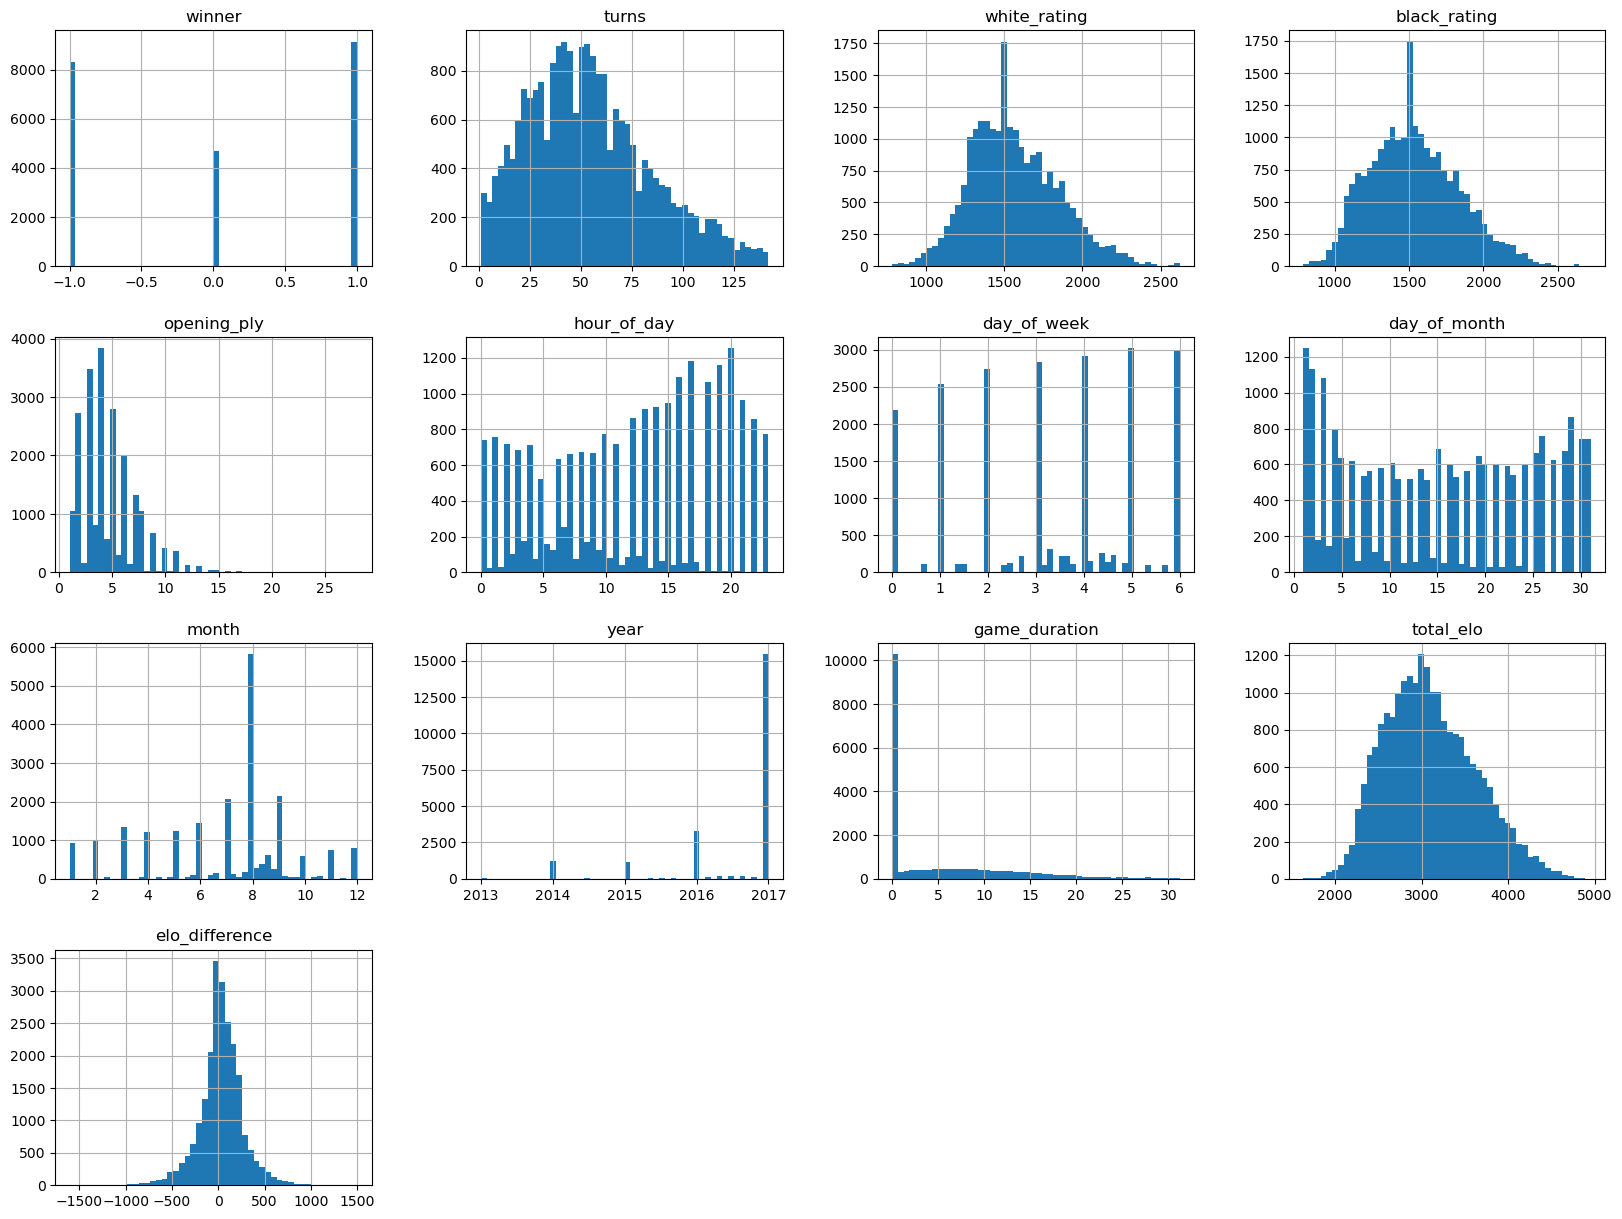

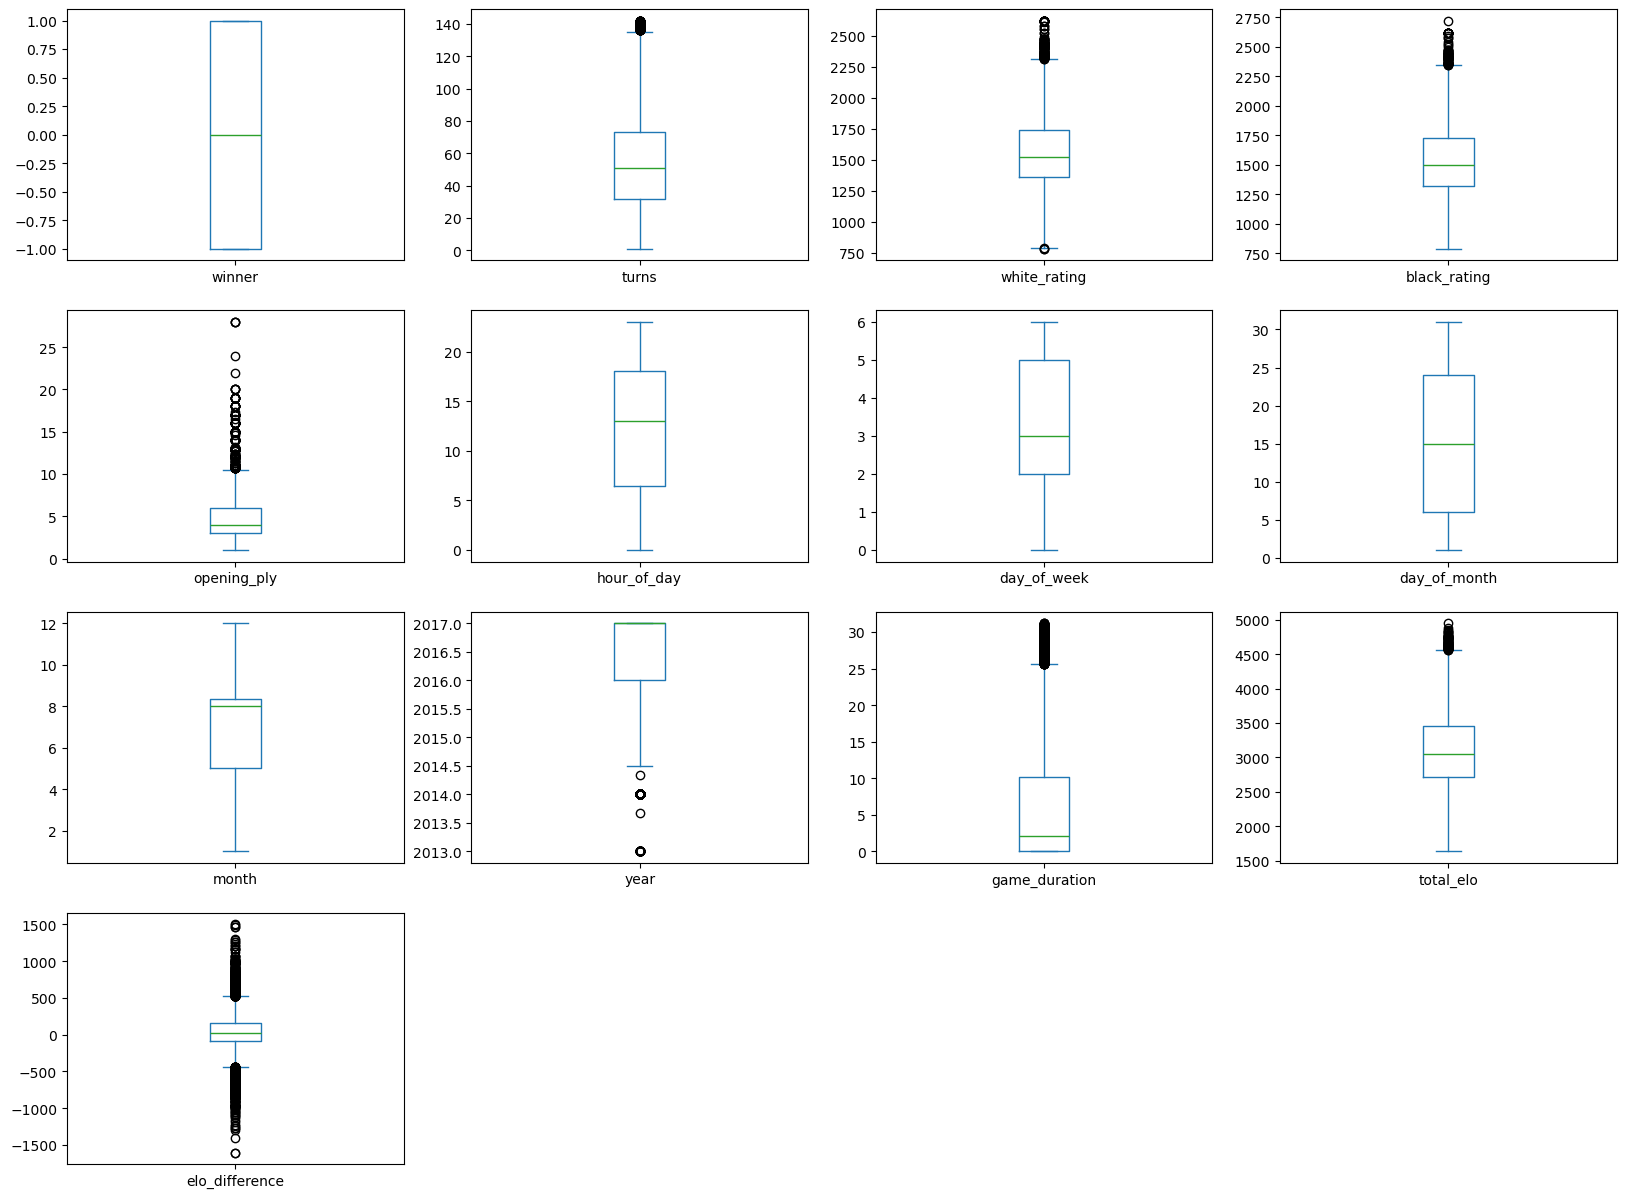

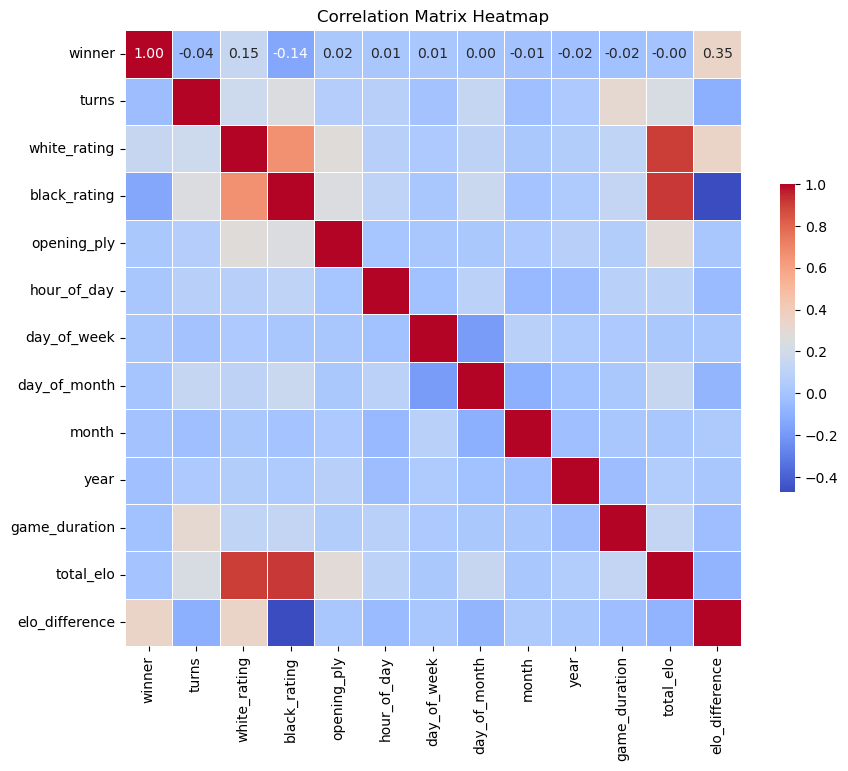

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
# Assuming df is your DataFrame

# Histogram of numerical data
df.hist(bins=50, figsize=(20,15))
plt.show()

# Boxplot of numerical data
df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 15))
plt.show()

# Calculating the correlation matrix
# Ensure that all involved columns are numeric, especially check the 'winner' column
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()


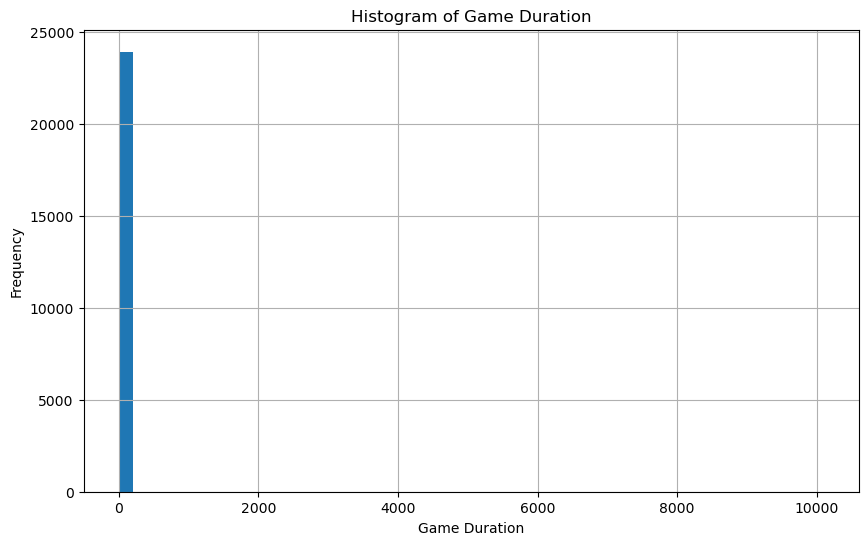

Summary Statistics for Game Duration:
count    23935.000000
mean        13.832128
std         74.865030
min          0.000000
25%          0.000000
50%          3.543583
75%         12.487275
max      10097.411683
Name: game_duration, dtype: float64

Number of Outliers: 1767

Flagged Outliers:
outlier_flag
No     22168
Yes     1767
Name: count, dtype: int64


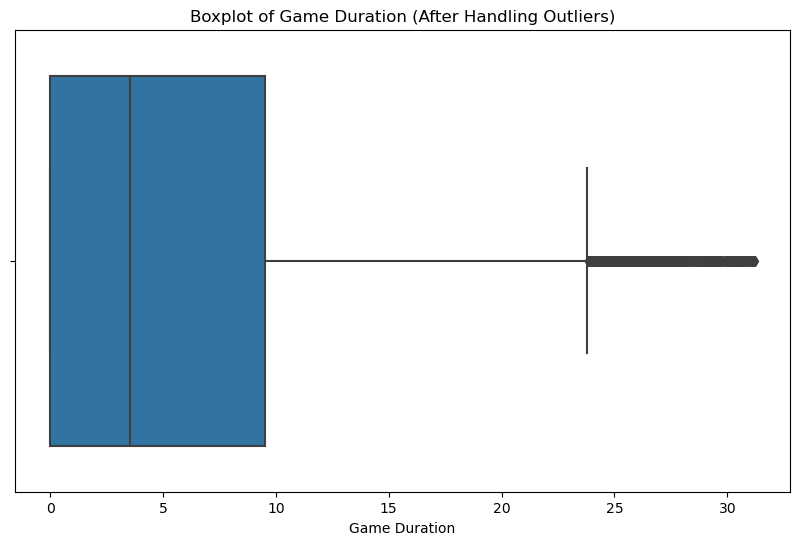

In [480]:
import pandas as pd



# Explore the distribution of 'game duration'
# Plot a histogram to visualize the distribution
df['game_duration'].hist(bins=50, figsize=(10, 6))
plt.title('Histogram of Game Duration')
plt.xlabel('Game Duration')
plt.ylabel('Frequency')
plt.show()

# Explore outliers in 'game duration'
# Calculate summary statistics
duration_stats = df['game_duration'].describe()

# Determine potential outliers using IQR method
Q1 = df['game_duration'].quantile(0.25)
Q3 = df['game_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['game_duration'] < lower_bound) | (df['game_duration'] > upper_bound)]

# Flag outliers for further investigation
df['outlier'] = (df['game_duration'] < lower_bound) | (df['game_duration'] > upper_bound)

# If outliers are due to data entry errors, you can correct or remove them
# Example of removing outliers
cleaned_df = df[~df['outlier']]

# Alternatively, you can impute missing or erroneous values
# Example of imputing outliers with median value
median_duration = df['game_duration'].median()
df.loc[df['outlier'], 'game_duration'] = median_duration

# You can also flag outliers for further investigation
# Example of flagging outliers
df['outlier_flag'] = df['outlier'].apply(lambda x: 'Yes' if x else 'No')

# Save the cleaned dataset to a new CSV file
# Replace 'cleaned_dataset.csv' with the desired filename
df.to_csv('cleaned_dataset.csv', index=False)

# Print summary statistics and flagging results
print("Summary Statistics for Game Duration:")
print(duration_stats)
print("\nNumber of Outliers:", len(outliers))
print("\nFlagged Outliers:")
print(df['outlier_flag'].value_counts())

# Display the boxplot after handling outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='game_duration', data=df)
plt.title('Boxplot of Game Duration (After Handling Outliers)')
plt.xlabel('Game Duration')
plt.show()




In [481]:
df = df[~df['outlier']]
df.drop(columns=['outlier','outlier_flag'], inplace=True)
print(df.head())

       winner      turns  white_rating  black_rating  opening_ply  \
14001     1.0  63.000000   1525.000000   1486.000000          2.0   
20344     0.0  21.666667   1343.666667   1147.333333          4.0   
3655     -1.0  14.000000   1153.000000   1370.000000          3.0   
18584     1.0  73.000000   1994.000000   1522.000000          2.0   
8157      1.0  51.000000   1390.000000   1386.000000          4.0   

       hour_of_day  day_of_week  day_of_month  month         year  \
14001         18.0     6.000000          27.0    8.0  2017.000000   
20344          5.5     3.666667           5.5    9.5  2016.833333   
3655          23.0     3.000000          22.0   12.0  2016.000000   
18584          9.0     5.000000           2.0    9.0  2017.000000   
8157           9.0     5.000000           2.0    4.0  2016.000000   

       game_duration  total_elo  elo_difference  
14001      15.992867     3011.0       39.000000  
20344       0.000000     2491.0      196.333333  
3655        0.000000


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [393]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Assuming df is your DataFrame and 'winner' is the target variable with classes [-1, 0, 1]
# Remapping target variable y: {-1: 0, 0: 1, 1: 2}
y = df['winner'].map({-1: 0, 0: 1, 1: 2})

# Extract features (X)
X = df[['white_rating', 'black_rating', 'opening_ply', 'elo_difference', 'turns', 'total_elo', 'day_of_week', 'day_of_month', 'hour_of_day', 'month', 'year','game_duration']]

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to train and evaluate models
def train_evaluate_model(model, X_train, X_test, y_train, y_test, scale=False):
    if scale:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    
    print(f"\n{model.__class__.__name__} F1 Score:", f1_score)
    print(classification_report(y_test, y_pred))
    return model, f1_score

# Models to train and evaluate
models = [
    (LogisticRegression(max_iter=1000), True),
    (DecisionTreeClassifier(), False),
    (RandomForestClassifier(), False),
    (SVC(), True),
    (KNeighborsClassifier(), True),
    (GradientBoostingClassifier(), False),
    (MLPClassifier(max_iter=1000), True),
    (AdaBoostClassifier(), False),
    (GaussianNB(), False),
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), False),
    (LGBMClassifier(), False)
]

# Train and evaluate all models
results = []
for model, needs_scaling in models:
    results.append(train_evaluate_model(model, X_train, X_test, y_train, y_test, scale=needs_scaling))


`use_label_encoder` is deprecated in 1.7.0.



LogisticRegression F1 Score: 0.594280895190482
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      2626
           1       0.64      0.72      0.68      2326
           2       0.58      0.54      0.56      3004

    accuracy                           0.60      7956
   macro avg       0.60      0.60      0.60      7956
weighted avg       0.59      0.60      0.59      7956


DecisionTreeClassifier F1 Score: 0.635921535955127
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2626
           1       0.82      0.83      0.82      2326
           2       0.58      0.58      0.58      3004

    accuracy                           0.64      7956
   macro avg       0.65      0.65      0.65      7956
weighted avg       0.64      0.64      0.64      7956


RandomForestClassifier F1 Score: 0.713628824168231
              precision    recall  f1-score   support

           0       0.60      0.

In [394]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

# Assuming df is your DataFrame and 'winner' is the target variable with classes [-1, 0, 1]
# Remapping target variable y: {-1: 0, 0: 1, 1: 2}
y = df['winner'].map({-1: 0, 0: 1, 1: 2})

# Extract features (X)
X = df[['white_rating', 'black_rating', 'opening_ply', 'elo_difference', 'turns', 'total_elo', 'day_of_week', 'day_of_month', 'hour_of_day', 'month', 'year','game_duration']]

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = LGBMClassifier()

# Define a simpler parameter grid
param_grid = {
    'num_leaves': [30, 40, 50],          # 3 options
    'max_depth': [15, 25, 35],           # 3 options
    'learning_rate': [0.05, 0.1, 0.15],  # 3 options
    'n_estimators': [100, 150, 200]      # 3 options
}

# Initialize the GridSearchCV object with reduced CV folds
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

# Evaluate the best model from grid search
print("Test Accuracy of Best Model: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 12375, number of used features: 12
[LightGBM] [Info] Start training from score -1.079404
[LightGBM] [Info] Start training from score -1.230586
[LightGBM] [Info] Start training from score -0.999453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 12375, number of used features: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

# Load dataset
y = df['winner'].map({-1: 0, 0: 1, 1: 2})  # Adjust the mapping accordingly
X = df.drop('winner', axis=1)  # Adjust the feature names accordingly

# Split data into training plus validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split training plus validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model initialization and training 'learning_rate': 0.15, 'max_depth': 35, 'n_estimators': 150, 'num_leaves': 30
model = LGBMClassifier(num_leaves=30, max_depth=35, learning_rate=0.15, n_estimators=150)
model.fit(X_train_scaled, y_train)

# Define different strategies for Dummy Classifier
strategies = ['most_frequent', 'stratified', 'uniform', 'prior']

# Create a dictionary to store results
dummy_results = {}

# Loop through strategies
for strategy in strategies:
    # Dummy Classifier
    dummy_classifier = DummyClassifier(strategy=strategy)
    dummy_classifier.fit(X_train_scaled, y_train)
    
    # Predictions using Dummy Classifier
    dummy_pred = dummy_classifier.predict(X_test_scaled)
    
    # Evaluate the dummy classifier on the test set
    dummy_f1_score = f1_score(y_test, dummy_pred, average='weighted')
    dummy_report = classification_report(y_test, dummy_pred)
    
    # Store results
    dummy_results[strategy] = {'f1_score': dummy_f1_score, 'classification_report': dummy_report}

# Predictions on test set
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model on the test set
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
test_report = classification_report(y_test, y_test_pred)

# Predictions on validation set
y_val_pred = model.predict(X_val_scaled)

# Evaluate the model on the validation set
val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
val_report = classification_report(y_val, y_val_pred)

# Extract feature importance from the trained model
feature_importances = model.feature_importances_
features_df = pd.DataFrame({
    'Feature Names': X.columns,
    'Feature Importance': feature_importances
}).sort_values(by='Feature Importance', ascending=False)

# Print or save the feature importance dataframe
print(features_df)
# If you want to save the dataframe to a CSV file
# features_df.to_csv('feature_importance.csv', index=False)

# Printing performance metrics
print("Test Set Performance (Model):")
print("F1 Score: {:.2f}".format(test_f1_score))
print("Classification Report:")
print(test_report)

print("\nValidation Set Performance (Model):")
print("F1 Score: {:.2f}".format(val_f1_score))
print("Classification Report:")
print(val_report)

# Printing performance metrics for Dummy Classifiers
print("\nDummy Classifier Performance:")
for strategy, result in dummy_results.items():
    print("\nStrategy:", strategy)
    print("F1 Score (Dummy): {:.2f}".format(result['f1_score']))
    print("Classification Report (Dummy):")
    print(result['classification_report'])



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1869
[LightGBM] [Info] Number of data points in the train set: 13300, number of used features: 12
[LightGBM] [Info] Start training from score -0.978126
[LightGBM] [Info] Start training from score -1.546075
[LightGBM] [Info] Start training from score -0.889400
     Feature Names  Feature Importance
0            turns                3808
11  elo_difference                1318
1     white_rating                1006
2     black_rating                1004
6     day_of_month                 973
4      hour_of_day                 903
9    game_duration                 819
10       total_elo                 817
7            month                 731
5      day_of_week                 730
3      opening_ply                 689
8             yea

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


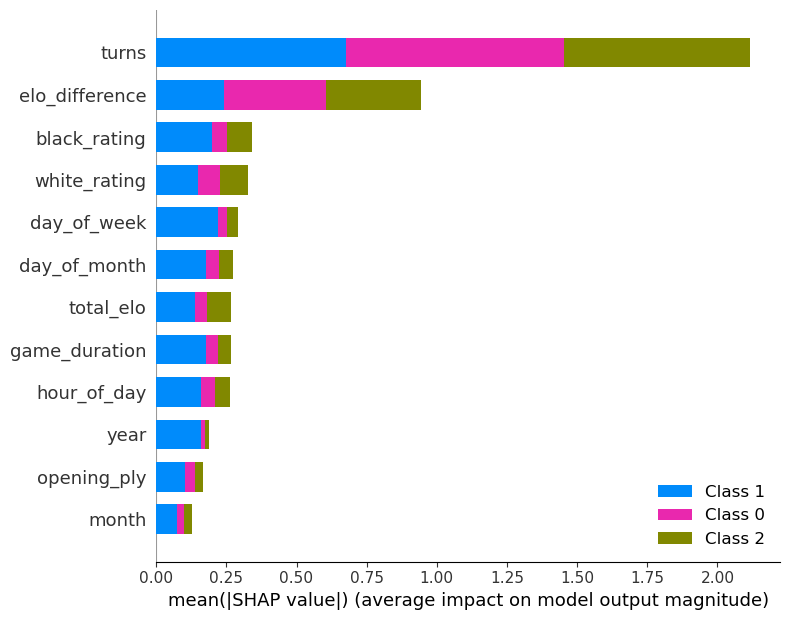

In [421]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns.tolist())



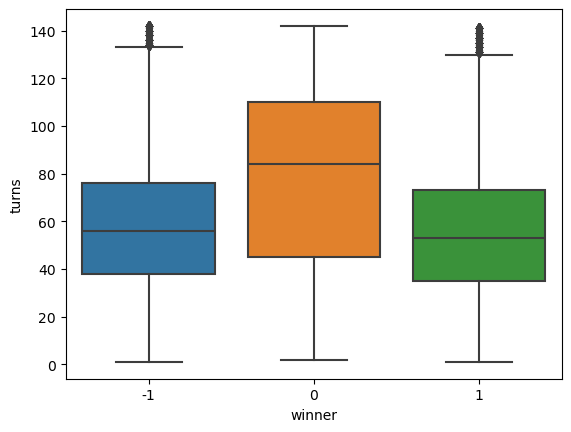

In [422]:

# Conditional distribution of target variable with respect to 'turns'
sns.boxplot(x='winner', y='turns', data=df)
plt.show()

In [483]:

#X_train_no_turns = X_train.drop(['turns','game_duration','opening_ply'], axis=1)
#X_test_no_turns = X_test.drop(['turns','game_duration','opening_ply'], axis=1)

X_train_no_turns = X_train.drop(['year'], axis=1)
X_test_no_turns = X_test.drop(['year'], axis=1)

# Re-scale data
scaler.fit(X_train_no_turns)
X_train_no_turns_scaled = scaler.transform(X_train_no_turns)
X_test_no_turns_scaled = scaler.transform(X_test_no_turns)

# Re-train model
model.fit(X_train_no_turns_scaled, y_train)
y_pred_no_turns = model.predict(X_test_no_turns_scaled)

# Evaluate performance
new_accuracy = accuracy_score(y_test, y_pred_no_turns)
print("New Accuracy without 'turns': {:.2f}%".format(new_accuracy * 100))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 13300, number of used features: 11
[LightGBM] [Info] Start training from score -0.978126
[LightGBM] [Info] Start training from score -1.546075
[LightGBM] [Info] Start training from score -0.889400
New Accuracy without 'turns': 86.51%


In [399]:
# Spearman's rank correlation
spearman_corr = df.corr(method='spearman')
print(spearman_corr['winner'].sort_values(ascending=False))

# Kendall's tau
kendall_tau = df.corr(method='kendall')
print(kendall_tau['winner'].sort_values(ascending=False))


winner            1.000000
elo_difference    0.321827
white_rating      0.125986
day_of_week       0.015707
hour_of_day       0.014244
opening_ply       0.012294
day_of_month      0.009536
month            -0.001334
total_elo        -0.004027
year             -0.019367
game_duration    -0.021827
turns            -0.044328
black_rating     -0.128422
Name: winner, dtype: float64
winner            1.000000
elo_difference    0.253268
white_rating      0.099657
day_of_week       0.013051
hour_of_day       0.011665
opening_ply       0.008650
day_of_month      0.007647
month            -0.001513
total_elo        -0.003263
year             -0.017562
game_duration    -0.018404
turns            -0.034352
black_rating     -0.100262
Name: winner, dtype: float64


In [400]:
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize PCA with desired number of components
pca = PCA(n_components=2)

# Fit PCA to your training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform your validation and test data using the trained PCA model
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize LGBMClassifier
clf = LGBMClassifier()

# Train the classifier using the transformed training data
clf.fit(X_train_pca, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val_pca)

# Evaluate the model on the validation set
val_accuracy_pca = accuracy_score(y_val, y_val_pred)
val_report_pca = classification_report(y_val, y_val_pred)

# Print performance metrics
print("Validation Set Performance after PCA:")
print("Accuracy: {:.2f}%".format(val_accuracy_pca * 100))
print("Classification Report:")
print(val_report_pca)

# Make predictions on the test set
y_test_pred_pca = clf.predict(X_test_pca)

# Evaluate the model on the test set
test_accuracy_pca = accuracy_score(y_test, y_test_pred_pca)
test_report_pca = classification_report(y_test, y_test_pred_pca)

# Print performance metrics
print("\nTest Set Performance after PCA:")
print("Accuracy: {:.2f}%".format(test_accuracy_pca * 100))
print("Classification Report:")
print(test_report_pca)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 15910, number of used features: 2
[LightGBM] [Info] Start training from score -1.091161
[LightGBM] [Info] Start training from score -1.228147
[LightGBM] [Info] Start training from score -0.990640
Validation Set Performance after PCA:
Accuracy: 57.45%
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59      1829
           1       0.61      0.65      0.63      1521
           2       0.52      0.51      0.51      1954

    accuracy                           0.57      5304
   macro avg       0.58      0.58      0.58      5304
weighted avg       0.57      0.57      0.57      5304


Test Set Performance after 

In [415]:
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize your estimator (LGBMClassifier)
estimator = LGBMClassifier()

# Initialize RFE with your estimator and desired number of features to keep
rfe = RFE(estimator, n_features_to_select=12)

# Fit RFE to your training data
rfe.fit(X_train_scaled, y_train)

# Transform your training, validation, and test data using the selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_val_rfe = rfe.transform(X_val_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

# Train the classifier using the transformed training data
clf = LGBMClassifier()
clf.fit(X_train_rfe, y_train)

# Make predictions on the validation set
y_val_pred_rfe = clf.predict(X_val_rfe)

# Evaluate the model on the validation set
val_accuracy_rfe = accuracy_score(y_val, y_val_pred_rfe)
val_report_rfe = classification_report(y_val, y_val_pred_rfe)

# Print performance metrics
print("Validation Set Performance after RFE:")
print("Accuracy: {:.2f}%".format(val_accuracy_rfe * 100))
print("Classification Report:")
print(val_report_rfe)

# Make predictions on the test set
y_test_pred_rfe = clf.predict(X_test_rfe)

# Evaluate the model on the test set
test_accuracy_rfe = accuracy_score(y_test, y_test_pred_rfe)
test_report_rfe = classification_report(y_test, y_test_pred_rfe)

# Print performance metrics
print("\nTest Set Performance after RFE:")
print("Accuracy: {:.2f}%".format(test_accuracy_rfe * 100))
print("Classification Report:")
print(test_report_rfe)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 15910, number of used features: 12
[LightGBM] [Info] Start training from score -1.091161
[LightGBM] [Info] Start training from score -1.228147
[LightGBM] [Info] Start training from score -0.990640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 15910, number of used features: 12
[LightGBM] [Info] Start training from score -1.091161
[LightGBM] [Info] Start training from score -1.228147
[LightGBM] [Info] Start 